In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

csv_files = glob.glob('results/*.csv')
colors = [
     'blue','green', 'red', 'purple', 'orange',  'cyan', 'magenta', 
    'yellow', 'black', 'pink', 'brown', 'gray', 'olive', 'lime', 
    'indigo', 'maroon', 'navy', 'teal', 'violet', 'gold', 'coral', 
    'turquoise', 'salmon', 'plum', 'orchid', 'crimson', 'khaki', 
    'lavender', 'sienna', 'tan']

In [166]:
import pandas as pd
import numpy as np
import os
from scipy.stats import wilcoxon

# Separate the files into two groups based on their names
group1_files = [file for file in csv_files if not os.path.basename(file).startswith('random')]
group2_files = [file for file in csv_files if os.path.basename(file).startswith('random')]

def calculate_stats(files):
    all_assigned_failures = []
    all_failure_duration = []
    all_success_rates = []
    total_failure_durations = []
    success_failure_ratios = []

    for csv_file in files:
        df = pd.read_csv(csv_file)
        operators = int(df['num_operators'].iloc[0])

        assigned_failures = []
        failure_duration = []
        success_rates = []
        

        for operator in range(operators):
            assigned_failures.append(df[f'{operator}_assigned_failures'].iloc[-1])
            rows_assigned = df[df['assigned_to'] == operator]
            failure_duration.append(rows_assigned['duration'].sum())
            success_rates.append(rows_assigned['success'].mean())

        total_failure_duration = df['duration'].sum()

        # Calculate the total number of successes and failures
        total_successes = df['success'].sum()
        total_failures = len(df) - total_successes
        success_failure_ratio = total_successes / len(df) if len(df) != 0 else np.nan

        all_assigned_failures.append(assigned_failures)
        all_failure_duration.append(failure_duration)
        all_success_rates.append(success_rates)
        total_failure_durations.append(total_failure_duration)
        success_failure_ratios.append(success_failure_ratio)

    assigned_failures_df = pd.DataFrame(all_assigned_failures)
    failure_duration_df = pd.DataFrame(all_failure_duration)
    success_rates_df = pd.DataFrame(all_success_rates)
    
    return assigned_failures_df, failure_duration_df, success_rates_df, total_failure_durations, success_failure_ratios, total_failures

# Calculate stats for both groups
group1_assigned_failures, group1_failure_duration, group1_success_rates, group1_total_failure_durations, group1_success_failure_ratios, group1_total_failures = calculate_stats(group1_files)
group2_assigned_failures, group2_failure_duration, group2_success_rates, group2_total_failure_durations, group2_success_failure_ratios, group2_total_failures = calculate_stats(group2_files)

# Calculate mean and std for each operator
group1_stats = {
    'assigned_failures': {
        'mean': group1_assigned_failures.mean(),
        'std': group1_assigned_failures.std()
    },
    'failure_duration': {
        'mean': group1_failure_duration.mean(),
        'std': group1_failure_duration.std()
    },
    'success_rates': {
        'mean': group1_success_rates.mean(),
        'std': group1_success_rates.std()
    },
    'total_failure_durations': {
        'mean': np.mean(group1_total_failure_durations),
        'std': np.std(group1_total_failure_durations)
    },
    'success_failure_ratio': {
        'mean': np.nanmean(group1_success_failure_ratios),
        'std': np.nanstd(group1_success_failure_ratios)
    },
    'total_failures': {
        'mean': np.mean(group1_total_failures),
        'std': np.std(group1_total_failures)
    }
}

group2_stats = {
    'assigned_failures': {
        'mean': group2_assigned_failures.mean(),
        'std': group2_assigned_failures.std()
    },
    'failure_duration': {
        'mean': group2_failure_duration.mean(),
        'std': group2_failure_duration.std()
    },
    'success_rates': {
        'mean': group2_success_rates.mean(),
        'std': group2_success_rates.std()
    },
    'total_failure_durations': {
        'mean': np.mean(group2_total_failure_durations),
        'std': np.std(group2_total_failure_durations)
    },
    'success_failure_ratio': {
        'mean': np.nanmean(group2_success_failure_ratios),
        'std': np.nanstd(group2_success_failure_ratios)
    },
    'total_failures': {
        'mean': np.mean(group2_total_failures),
        'std': np.std(group2_total_failures)
    }

}

# Print the statistics
print("Group 1 Stats:")
# print(group1_stats)
print("\nGroup 2 Stats:")
# print(group2_stats)

# Perform the Wilcoxon signed-rank test
_, p_value_ratio = wilcoxon(group1_success_failure_ratios, group2_success_failure_ratios)

# Calculate mean and standard deviation for both groups
mean_group1 = np.nanmean(group1_success_failure_ratios)
mean_group2 = np.nanmean(group2_success_failure_ratios)
std_group1 = np.nanstd(group1_success_failure_ratios)
std_group2 = np.nanstd(group2_success_failure_ratios)

# Print results
print(f"Wilcoxon signed-rank test for overall team success (success/failure ratio):")
print(f"Mean Group 1: {mean_group1}, Std Group 1: {std_group1}")
print(f"Mean Group 2: {mean_group2}, Std Group 2: {std_group2}")
print(f"P-value: {p_value_ratio}\n")

# Perform Wilcoxon signed-rank test for overall team duration
stat_duration, p_value_duration = wilcoxon(group1_total_failure_durations, group2_total_failure_durations)
print(f"Wilcoxon signed-rank test for overall team duration:")
print(f"Mean Group 1: {np.mean(group1_total_failure_durations)}, Mean Group 2: {np.mean(group2_total_failure_durations)}")
print(f"P-value: {p_value_duration}\n")

# Perform Wilcoxon signed-rank test for personal success
for operator in range(group1_success_rates.shape[1]):
    try:
        if not (group1_success_rates.iloc[:, operator] - group2_success_rates.iloc[:, operator]).equals(pd.Series([0]*len(group1_success_rates))):
            stat_success, p_value_success = wilcoxon(group1_success_rates.iloc[:, operator], group2_success_rates.iloc[:, operator])
            print(f"Wilcoxon signed-rank test for personal success of operator {operator}:")
            print(f"Mean Group 1: {group1_success_rates.iloc[:, operator].mean()}, Mean Group 2: {group2_success_rates.iloc[:, operator].mean()}")
            print(f"P-value: {p_value_success}\n")
        else:
            print(f"Wilcoxon test for personal success of operator {operator} not performed due to no variability.")
    except ValueError as e:
        print(f"Wilcoxon test for personal success of operator {operator} failed: {e}")

# Perform Wilcoxon signed-rank test for personal duration
for operator in range(group1_failure_duration.shape[1]):
    try:
        if not (group1_failure_duration.iloc[:, operator] - group2_failure_duration.iloc[:, operator]).equals(pd.Series([0]*len(group1_failure_duration))):
            stat_duration, p_value_duration = wilcoxon(group1_failure_duration.iloc[:, operator], group2_failure_duration.iloc[:, operator])
            print(f"Wilcoxon signed-rank test for personal duration of operator {operator}:")
            print(f"Mean Group 1: {group1_failure_duration.iloc[:, operator].mean()}, Mean Group 2: {group2_failure_duration.iloc[:, operator].mean()}")
            print(f"P-value: {p_value_duration}\n")
        else:
            print(f"Wilcoxon test for personal duration of operator {operator} not performed due to no variability.")
    except ValueError as e:
        print(f"Wilcoxon test for personal duration of operator {operator} failed: {e}")

Group 1 Stats:

Group 2 Stats:
Wilcoxon signed-rank test for overall team success (success/failure ratio):
Mean Group 1: 0.9550000000000001, Std Group 1: 0.017748239349298842
Mean Group 2: 0.794, Std Group 2: 0.04521061822182926
P-value: 1.9073486328125e-06

Wilcoxon signed-rank test for overall team duration:
Mean Group 1: 1982.6, Mean Group 2: 2447.9
P-value: 1.9073486328125e-06

Wilcoxon test for personal success of operator 0 failed: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.
Wilcoxon signed-rank test for personal success of operator 1:
Mean Group 1: 0.8448832417582418, Mean Group 2: 0.623845569236176
P-value: 1.9073486328125e-06

Wilcoxon signed-rank test for personal duration of operator 0:
Mean Group 1: 1042.2, Mean Group 2: 677.2
P-value: 1.9073486328125e-06

Wilcoxon signed-rank test for personal duration of operator 1:
Mean Group 1: 940.4, Mean Group 2: 1770.7
P-value: 1.9073486328125e-06



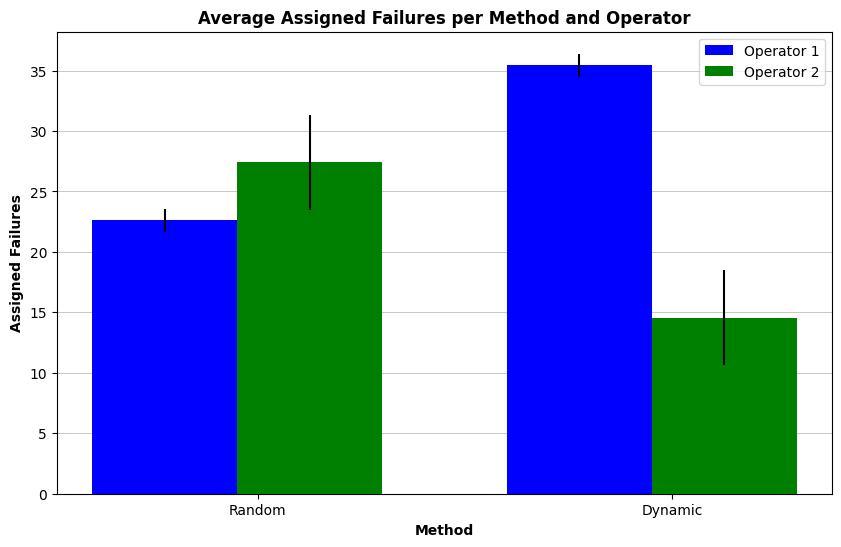

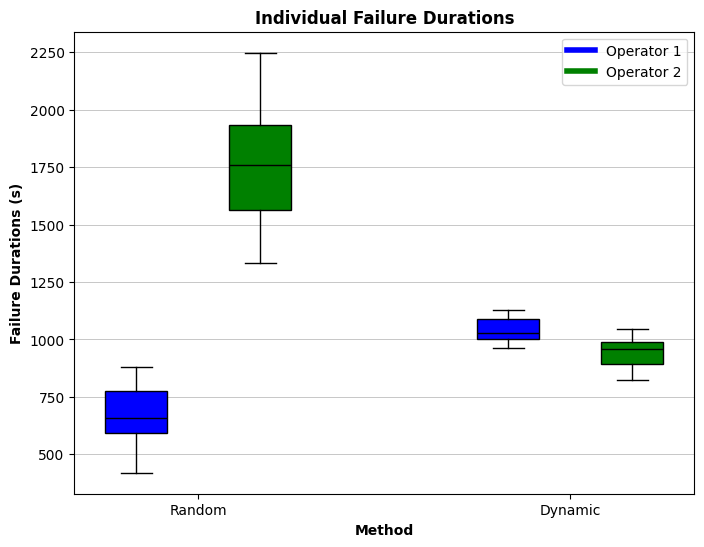

C:\Users\lgenua\AppData\Local\Temp\ipykernel_24584\2619531922.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group1_success_rates.values.flatten(), group2_success_rates.values.flatten()], labels=['Dynamic Assignment', 'Random Assignment'], medianprops=dict(color='black'))


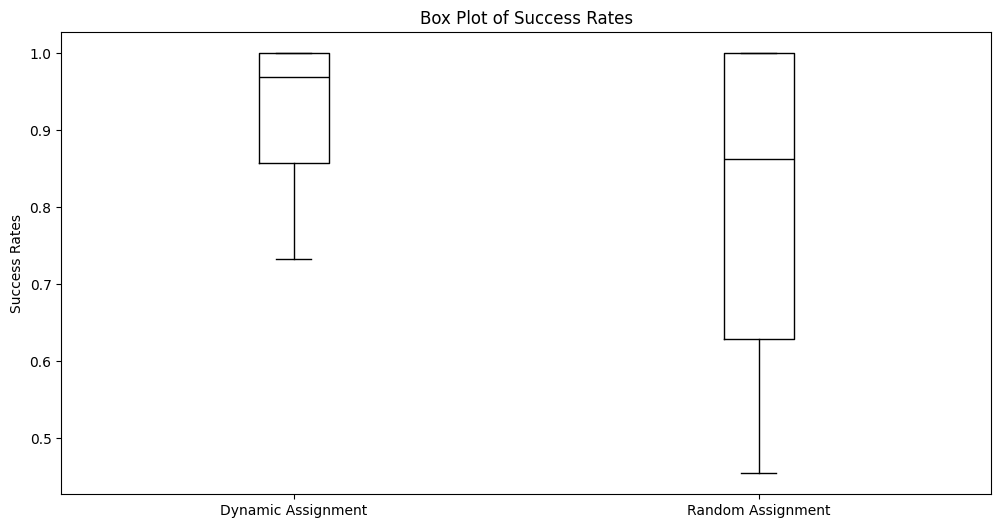

In [173]:
# Define colors for each operator
operator_colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown']
operator_labels = [f'Operator {i+1}' for i in range(len(group1_failure_duration.columns))]

# Plot 1: Bar plot for average assigned failures (stacked bars for operators) with standard deviation
group1_mean_assigned_failures = group1_assigned_failures.mean(axis=0)
group2_mean_assigned_failures = group2_assigned_failures.mean(axis=0)
group1_std_assigned_failures = group1_assigned_failures.std(axis=0)
group2_std_assigned_failures = group2_assigned_failures.std(axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)  # 2 operators

# Adjusting indices for grouped bar plot
dynamic_indices = index
random_indices = index + bar_width  # Adding a small space between groups

bar1 = ax.bar(dynamic_indices, [group2_mean_assigned_failures[0], group1_mean_assigned_failures[0]], bar_width, yerr=group1_std_assigned_failures, color=operator_colors[0], label='Operator 1', zorder=3)
bar2 = ax.bar(random_indices, [group2_mean_assigned_failures[1], group1_mean_assigned_failures[1]], bar_width, yerr=group2_std_assigned_failures, color=operator_colors[1], label='Operator 2', zorder=3)

# Setting labels and title
ax.set_xlabel('Method', fontweight='bold')
ax.set_ylabel('Assigned Failures', fontweight='bold')
ax.set_title('Average Assigned Failures per Method and Operator', fontweight='bold')

# Setting custom x-tick labels
ax.set_xticks(index + (bar_width + 0.1) / 2)
ax.set_xticklabels(['Random', 'Dynamic'])

# Adding legend
ax.legend()
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5, zorder=0)
plt.show()

data_rand_op1 = group2_failure_duration[0]
data_rand_op2 = group2_failure_duration[1]
data_dyn_op1 = group1_failure_duration[0]
data_dyn_op2 = group1_failure_duration[1]
data = [data_rand_op1, data_rand_op2, data_dyn_op1, data_dyn_op2]

operator_colors = ['blue', 'green', 'blue', 'green']
operator_labels = ['Operator 1', 'Operator 2']
# Custom positions for the boxes
positions = [1, 2, 4, 5]

# Create the boxplot
plt.figure(figsize=(8, 6))
box = plt.boxplot(data, positions=positions, patch_artist=True, medianprops=dict(color='black'))

# Set colors for each box
for patch, color in zip(box['boxes'], operator_colors):
    patch.set_facecolor(color)

# Customizing the plot
plt.xlabel('Method', fontweight='bold')
plt.xticks([1.5, 4.5], ['Random', 'Dynamic'])
plt.ylabel('Failure Durations (s)', fontweight='bold')
plt.title('Individual Failure Durations', fontweight='bold')
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Operator 1'),
           plt.Line2D([0], [0], color='green', lw=4, label='Operator 2')]
plt.legend(handles=handles)
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5)
plt.show()

# Plot 3: Box plot for success rates
plt.figure(figsize=(12, 6))
plt.boxplot([group1_success_rates.values.flatten(), group2_success_rates.values.flatten()], labels=['Dynamic Assignment', 'Random Assignment'], medianprops=dict(color='black'))
plt.title('Box Plot of Success Rates')
plt.ylabel('Success Rates')
plt.show()